In [5]:
#import necessary modules
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.morphology import label
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Define parameters and constants

In [6]:
IMG_SCALING = (1, 1)
DATA_FOLDER = 'data'
train_image_dir = os.path.join(DATA_FOLDER, 'train_v2')
test_image_dir = os.path.join(DATA_FOLDER, 'test_v2')
mask_csv = os.path.join(DATA_FOLDER, 'train_ship_segmentations_v2.csv')

Define functions to decode and encode the images

In [7]:
# Function to perform multi-run length encoding of an image
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]


# Function to run-length encode an image
# Ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


# Function to decode a run-length encoded mask
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

Create masks of ships

In [8]:
# Function to combine individual ship masks into a single mask array
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype=np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

Generate batches of images and label generators

In [9]:
# Function to generate batches of images and masks
def make_image_gen(in_df, batch_size=4):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

Apply augmentation

In [10]:
# Augmentation arguments for the image and label generators
dg_args = dict(featurewise_center = False,
                  samplewise_center = False,
                  rotation_range = 15,
                  width_shift_range = 0.1,
                  height_shift_range = 0.1,
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],
                  horizontal_flip = True,
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')

# Create an image generator with augmentation parameters
image_gen = ImageDataGenerator(**dg_args)

# Create a label generator with augmentation parameters
label_gen = ImageDataGenerator(**dg_args)

In [11]:
# Function to create an augmented generator
def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)
        g_y = label_gen.flow(in_y,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

Look at masks

In [12]:
masks = pd.read_csv(mask_csv, header=0)
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Check how encoding-decoding works

Check Decoding->Encoding RLE_0: 1 -> RLE_1: 1


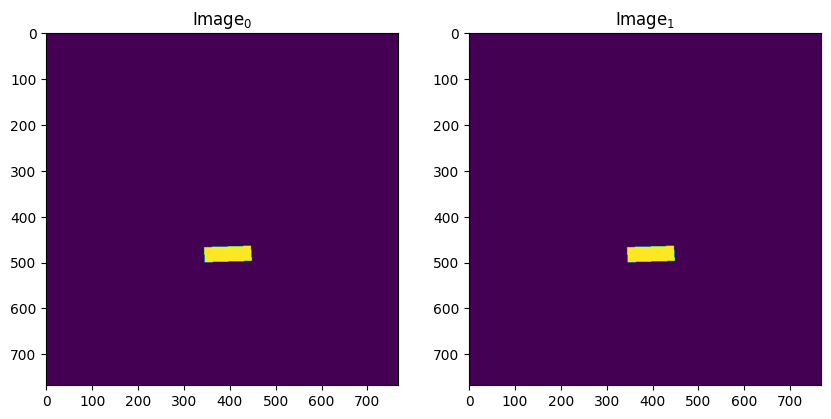

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="000155de5.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

Look at first 5 samples

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
22663,1e17f7d6a.jpg,2,1.0,[1.0],268.518555
73135,61497e6ea.jpg,0,0.0,[0.0],174.956055
135984,b4bf54113.jpg,0,0.0,[0.0],110.122070
84754,70a7e55ef.jpg,0,0.0,[0.0],222.355469
25954,229241182.jpg,4,1.0,[1.0],122.773438


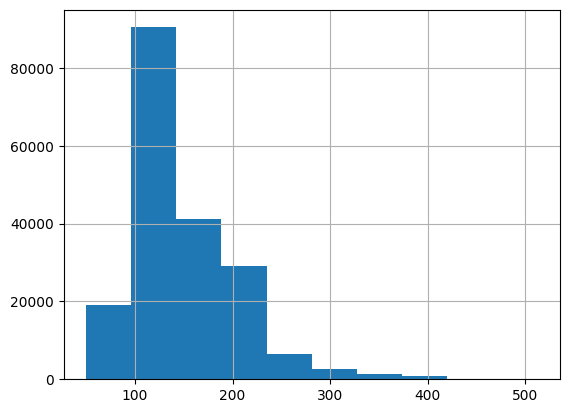

In [14]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

Look how often ships appear

<Axes: >

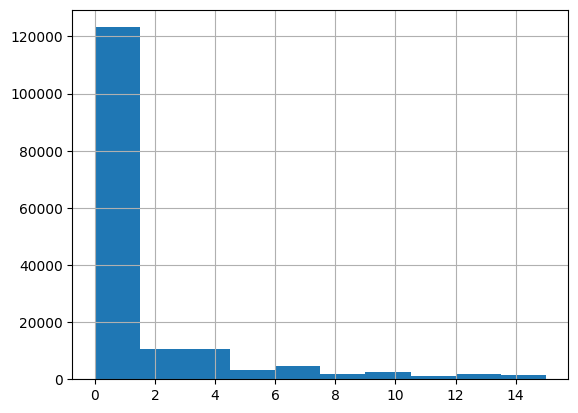

In [15]:
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
train_df['ships'].hist()

Undersample the empty images to get a better balanced group

<Axes: >

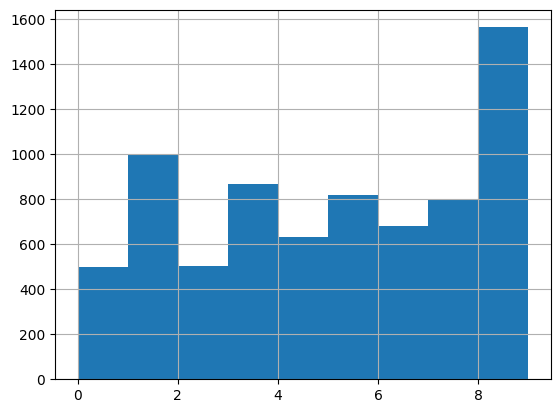

In [16]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)
def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0]==0:
        return in_df.sample(base_rep_val//3) # even more strongly undersample no ships
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))
    
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))